<a href="https://colab.research.google.com/github/kdzioba/machine-learning-bootcamp/blob/main/regresja_liniowa/04_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.set()
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
sklearn.__version__

'0.22.2.post1'

In [2]:
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Eksplorcja i wstępne przygotowanie danych


In [7]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges


In [5]:
df[df['charges'] == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [8]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

In [11]:
for col in cat_cols:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.5 KB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [13]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [14]:
df.sex.value_counts()

male      675
female    662
Name: sex, dtype: int64

In [16]:
df.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [17]:
df.region.value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

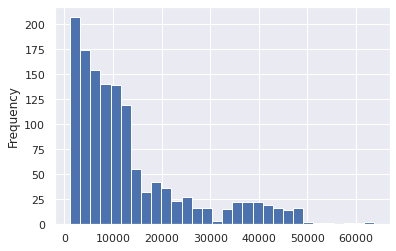

In [18]:
df.charges.plot(kind='hist', bins=30)

In [19]:
import plotly.express as px

px.histogram(df, x='charges', width=700, height=400, nbins=50, facet_col='smoker', facet_row='sex')

In [20]:
px.histogram(df, x='smoker', facet_col='sex', color='sex', width=700, height=400)

In [21]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [22]:
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


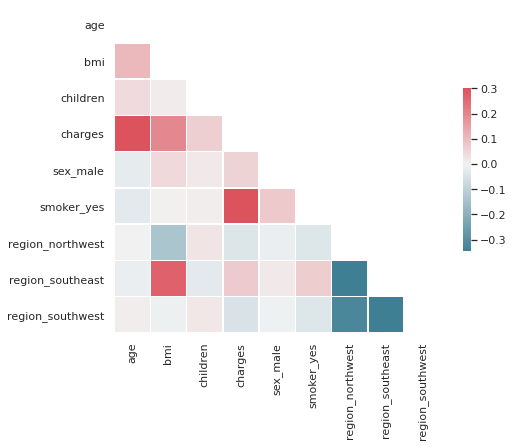

In [23]:
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
df_dummies.corr()['charges'].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64

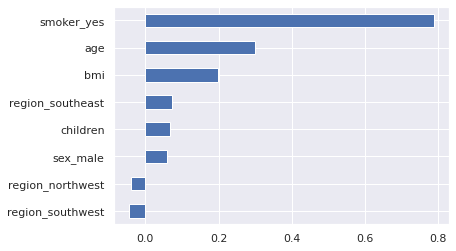

In [25]:
sns.set()
df_dummies.corr()['charges'].sort_values()[:-1].plot(kind='barh')

In [26]:
data = df_dummies.copy()
target = data.pop('charges')
data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


Podział danych na zbiór treningowy i testowy

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

print(f'X_trian shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_trian shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_trian shape: (1069, 8)
X_test shape: (268, 8)
y_trian shape: (1069,)
y_test shape: (268,)


Regresja liniowa

In [29]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
print(f'R2 score: {regressor.score(X_test, y_test):.4f}')

R2 score: 0.8069


In [31]:
y_pred = regressor.predict(X_test)
y_pred[:10]

array([ 8143.6939,  5737.1157, 14369.3149, 31745.5136,  8962.3867,
       13149.7224, 30446.7607,  1453.2888, 10633.0184, 11318.9438])

In [32]:
y_true = y_test.copy()
predictions = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true'] -  predictions['y_pred']
predictions.head()

,y_true,y_pred,error
900,8688.85885,8143.693884,545.164966
1064,5708.86700,5737.115683,-28.248683
1256,11436.73815,14369.314876,-2932.576726
298,38746.35510,31745.513636,7000.841464
237,4463.20510,8962.386657,-4499.181557


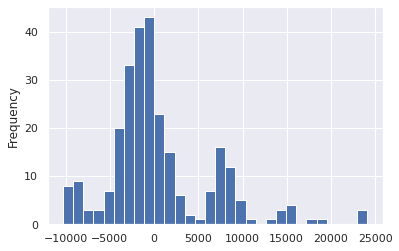

In [33]:
predictions.error.plot(kind='hist', bins=30)

In [34]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi: {mae:.2f}')

MAE wynosi: 4177.05


In [35]:
regressor.intercept_

-11092.65229594595

In [36]:
regressor.coef_

array([  248.2107,   318.7014,   533.01  ,  -101.5421, 23077.7646,
        -391.7615,  -838.9196,  -659.1398])

In [37]:
data.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

Dobór cech modelu - eliminacja wsteczna

In [49]:
import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)
X_train_ols

array([[ 1.   , 23.   , 24.51 , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 21.   , 25.745, ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 52.   , 37.525, ...,  1.   ,  0.   ,  0.   ],
       ...,
       [ 1.   , 20.   , 22.   , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 38.   , 28.   , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 35.   , 35.86 , ...,  0.   ,  1.   ,  0.   ]])

In [53]:
ols = sm.OLS(endog=y_train, exog=X_train_ols).fit()
predictors = ['const'] + list(X_train.columns)
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          4.94e-295
Time:                        19:59:25   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.109e+04   1114.260  

In [54]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 6, 7, 8]]
predictors.remove('sex_male')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     409.6
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          2.44e-296
Time:                        19:59:29   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1061   BIC:                         2.172e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.113e+04   1102.801  

In [55]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7, 8]]
predictors.remove('region_northwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     478.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          1.40e-297
Time:                        19:59:33   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1062   BIC:                         2.171e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.132e+04   1072.467  

In [56]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7]]
predictors.remove('region_southwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     573.4
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          8.97e-299
Time:                        19:59:37   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1063   BIC:                         2.171e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.139e+04   1069.862  

In [57]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5]]
predictors.remove('region_southeast')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     716.3
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          5.56e-300
Time:                        19:59:42   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.167e+04
Df Residuals:                    1064   BIC:                         2.170e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.126e+04   1062.104    -10.599      0.0

In [59]:
predictors

['const', 'age', 'bmi', 'children', 'smoker_yes']

Eliminacja wsteczna - automatyzacja

In [60]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])

predictors = ['const'] + list(X_train.columns)
sl = 0.05

for i in range(0, num_vars):
    ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
    max_pval = max(ols.pvalues.astype('float'))
    if max_pval > sl:
        for j in range(0, num_vars - i):
            if ols.pvalues[j].astype('float') == max_pval:
                X_train_numpy = np.delete(X_train_numpy, j, axis=1)
                predictors.remove(predictors[j])

print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     716.3
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          5.56e-300
Time:                        20:00:42   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.167e+04
Df Residuals:                    1064   BIC:                         2.170e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.126e+04   1062.104    -10.599      0.0